## Import your stuff

In [1]:
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions

from pydelfi import delfi

from simulators.jla_supernovae import jla_simulator as jla

## Set up the simulator
This must have the signature `simulator(parameters, seed, args, batch)` -> `np.array([batch, ndata])`

In [2]:
JLASimulator = jla.JLA_Model()

def simulator(theta, seed, simulator_args, batch):
    
    return JLASimulator.simulation(theta, seed)

simulator_args = None

/Users/charnock/Physics/pydelfi/examples/simulators/jla_supernovae/jla_parser.py:9: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  dtype = None, names = True)


## Set up the prior

In [3]:
lower = np.array([0, -1.5, -20, 0, 0, -0.5])
upper = np.array([0.6, 0, -18, 1, 6, 0.5])
prior = tfd.Blockwise([tfd.Uniform(low=lower[i], high=upper[i]) for i in range(6)])

## Set up the compressor
Must have the signature `compressor(data, args)` -> `np.array([n_summaries])`<br>
In this case we are going to do Gaussian score compression $$\mathbf{t} = \boldsymbol\theta_* + \mathbf{F}^{-1}\nabla_\theta^T\boldsymbol\mu_*\mathbf{C}^{-1}(\mathbf{d}-\boldsymbol\mu_*)$$ using the class `score.Gaussian`. For this we'll need some fiducial parameters, the mean its derivative at the fiducial parameters, the inverse covariance, and the inverse Fisher matrix

In [4]:
from pydelfi import score
theta_fiducial = np.array([0.2, -0.75, -19.05, 0.125, 2.65, -0.05])

mu = JLASimulator.apparent_magnitude(theta_fiducial)
Cinv = JLASimulator.Cinv

h = np.array(abs(theta_fiducial))*0.01
dmudt = JLASimulator.dmudt(theta_fiducial, h)

Compressor = score.Gaussian(len(JLASimulator.data), theta_fiducial, mu = mu, Cinv = Cinv, dmudt = dmudt)
Compressor.compute_fisher()
Finv = Compressor.Finv

def compressor(d, compressor_args):
    return Compressor.scoreMLE(d)
compressor_args=None

## Load in the compressed data

In [5]:
compressed_data = compressor(JLASimulator.data, compressor_args)

## Define ensemble of NDEs

We can now use any tfp.distribution, for example a MAF. Note that we need the distribution to be conditional on the parameters, i.e. 3 MAFs can be made like

```python
tfb = tfp.bijectors
NDEs = [tfd.TransformedDistribution(
            distribution=tfd.Normal(loc=0., scale=1.),
            bijector=tfb.MaskedAutoregressiveFlow(
                shift_and_log_scale_fn=tfb.AutoregressiveNetwork(
                    params=2, 
                    hidden_units=[50, 50], 
                    activation=tf.keras.activations.tanh,
                    event_shape=[6],
                    conditional=True,
                    conditional_shape=[6],
                    conditional_input_all_layers=True)),
            event_shape=[6]) 
        for i in range(3)]
```

Note for convenience, the pydelfi.ndes module has a wrapper

In [6]:
from pydelfi import ndes
NDEs = [ndes.ConditionalMaskedAutoregressiveFlow(
            n_parameters=6,
            n_data=6, 
            n_hidden=[50,50], 
            activation=tf.keras.activations.tanh, 
            all_layers=True)
        for i in range(3)]

## Create DELFI object

In [7]:
DelfiEnsemble = delfi.Delfi(compressed_data, prior, NDEs, 
                            Finv = Finv, 
                            theta_fiducial = theta_fiducial, 
                            param_limits = [lower, upper],
                            param_names = ['\\Omega_m', 'w_0', 'M_\mathrm{B}', '\\alpha', '\\beta', '\\delta M'], 
                            results_dir = "simulators/jla_supernovae/results/",
                            input_normalization="fisher",
                            optimiser=tf.keras.optimizers.Adam,
                            optimiser_arguments=None,
                            dtype=tf.float32)

## Fisher pre-training to initialize the NDEs

Sampling approximate posterior...


/usr/local/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
W0316 22:35:27.098325 4465880512 mcsamples.py:1172] auto bandwidth for \Omega_m very small or failed (h=0.0001905196207007491,N_eff=10000.0). Using fallback (h=0.023784654400538785)
W0316 22:35:27.173447 4465880512 mcsamples.py:1172] auto bandwidth for w_0 very small or failed (h=0.0001789984301188774,N_eff=10000.0). Using fallback (h=0.024236998087429146)


Done.
Removed no burn in


W0316 22:35:27.244434 4465880512 mcsamples.py:1172] auto bandwidth for M_\mathrm{B} very small or failed (h=0.00018802571408803643,N_eff=10000.0). Using fallback (h=0.022686717335429152)
W0316 22:35:27.295370 4465880512 mcsamples.py:1172] auto bandwidth for \alpha very small or failed (h=0.00018712552667721633,N_eff=10000.0). Using fallback (h=0.026251060120321384)
W0316 22:35:27.338324 4465880512 mcsamples.py:1172] auto bandwidth for \beta very small or failed (h=0.00018541590339256854,N_eff=10000.0). Using fallback (h=0.022664171784678878)
W0316 22:35:27.374781 4465880512 mcsamples.py:1172] auto bandwidth for \delta very small or failed (h=0.0001915383611746972,N_eff=10000.0). Using fallback (h=0.024400044781559813)
W0316 22:35:32.762700 4465880512 mcsamples.py:1707] fine_bins_2D not large enough for optimal density
W0316 22:35:32.891644 4465880512 mcsamples.py:1707] fine_bins_2D not large enough for optimal density
W0316 22:35:33.041642 4465880512 mcsamples.py:1707] fine_bins_2D not

ValueError: Contour levels must be increasing

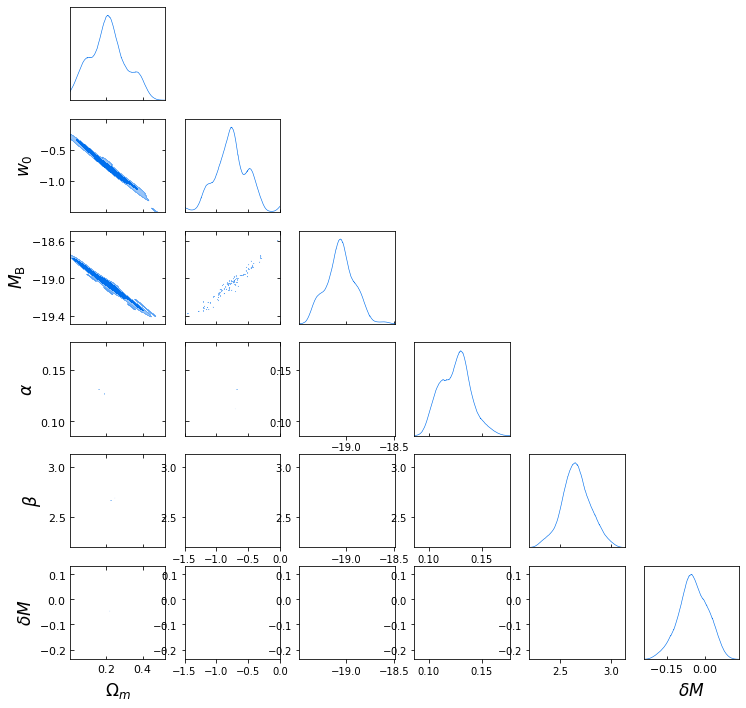

In [8]:
DelfiEnsemble.fisher_pretraining(epochs=50, plot=True)

## Sequential Neural Likelihood

Training terminated early at epoch 112.
Sampling approximate posterior...


/Users/justinalsing/Dropbox/science/pydelfi-tf2/pydelfi/pydelfi/delfi.py:224: RuntimeWarning: divide by zero encountered in log
  lnL = np.log(L)


Done.
Removed no burn in


/usr/local/lib/python3.7/site-packages/matplotlib/figure.py:2359: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


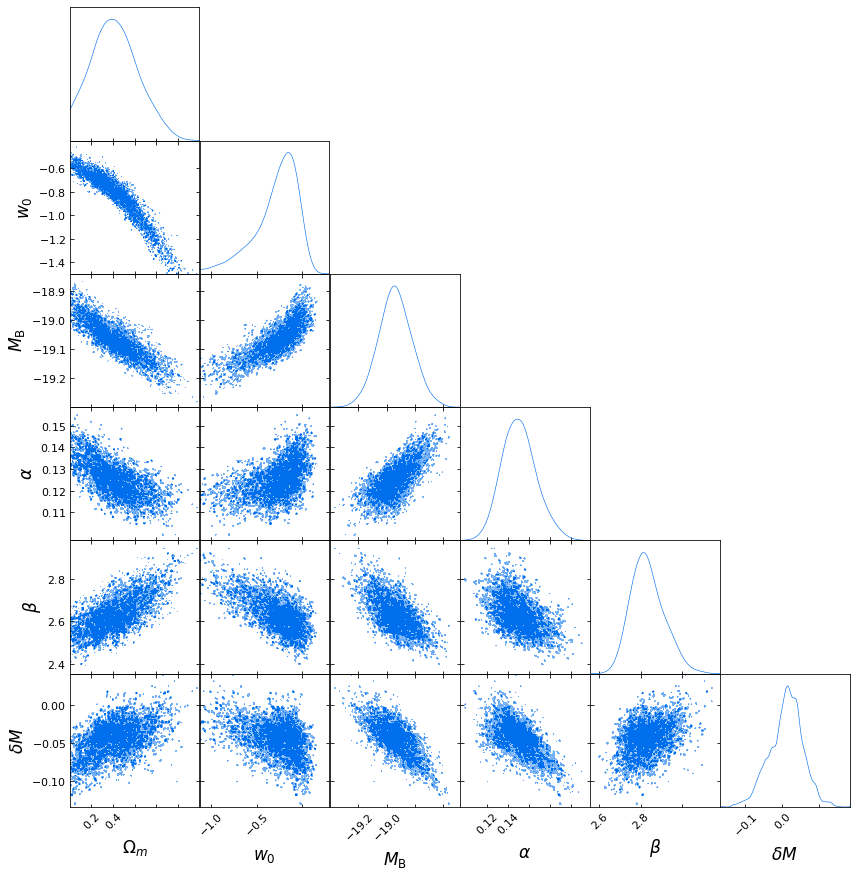

Population 1/10
Sampling proposal density...
emcee: Exception while calling your likelihood function:
  params: [  0.18141711  -0.74425771 -18.99292775   0.13540764   2.53862124
  -0.04755239]
  args: []
  kwargs: {}
  exception:


Traceback (most recent call last):
  File "/usr/local/lib/python3.7/site-packages/emcee/ensemble.py", line 545, in __call__
    return self.f(x, *self.args, **self.kwargs)
  File "/Users/justinalsing/Dropbox/science/pydelfi-tf2/pydelfi/pydelfi/delfi.py", line 440, in <lambda>
    self.emcee_sample(log_likelihood = lambda x: self.log_geometric_mean_proposal_stacked(x, self.data).numpy(), \
  File "/Users/justinalsing/Dropbox/science/pydelfi-tf2/pydelfi/pydelfi/delfi.py", line 241, in log_geometric_mean_proposal_stacked
    return 0.5 * (self.log_likelihood_stacked(x, data) + 2 * tf.cast(self.prior.log_prob(np.atleast_2d(theta).astype(np.float32)), tf.float32) )
NameError: name 'theta' is not defined


NameError: name 'theta' is not defined

In [8]:
n_initial = 200
n_batch = 200
n_populations = 10

DelfiEnsemble.sequential_training(simulator, compressor, n_initial, n_batch, n_populations, patience=20, save_intermediate_posteriors=True)

## Sample the learned posterior

In [ ]:
posterior_samples = DelfiEnsemble.emcee_sample()

## Alright let's plot it!
Feed it a list of `(n_samples, n_parameters)` arrays for making a triangle plot; in this case let's just plot the posterior samples.

In [ ]:
DelfiEnsemble.triangle_plot(samples=[posterior_samples])

In [8]:
import getdist
getdist.__version__

'1.1.0'

In [20]:
import tensorflow_probability as tfp
tfd = tfp.distributions

In [11]:
NDEs3[0].log_prob(np.atleast_2d(theta_fiducial).astype(np.float32), np.atleast_2d(theta_fiducial).astype(np.float32))

<tf.Tensor: shape=(1,), dtype=float32, numpy=array([-108.01955], dtype=float32)>

In [8]:
DelfiEnsemble3.log_posterior_stacked(theta_fiducial, theta_fiducial)

<tf.Tensor: shape=(1,), dtype=float64, numpy=array([-0.30318829])>

In [8]:
def target(theta):
    
    return NDEs3[0].log_prob(np.atleast_2d(compressed_data).astype(np.float32), np.atleast_2d(theta)) + tf.cast(prior.log_prob(theta), tf.float32)

In [16]:
import time
num_results = 500
init_state = [tf.constant(theta_fiducial, dtype=tf.float32)]

start = time.time()
chain, _ = tfp.mcmc.sample_chain(
  num_results=num_results,
  current_state=init_state,
  kernel=tfp.mcmc.SliceSampler(
      target_log_prob_fn=target,
      step_size=1.0,
      max_doublings=5,
      seed=47),
  num_burnin_steps=200,
  num_steps_between_results=1,
  parallel_iterations=1)
print(time.time() - start)

/usr/local/lib/python3.7/site-packages/tensorflow_probability/python/mcmc/sample.py:333: UserWarning: Tracing all kernel results by default is deprecated. Set the `trace_fn` argument to None (the future default value) or an explicit callback that traces the values you are interested in.
  warnings.warn("Tracing all kernel results by default is deprecated. Set "


278.89853620529175


In [19]:
%timeit target(theta_fiducial.astype(np.float32))

6.61 ms ± 1.14 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


Removed no burn in


NameError: name 'plt' is not defined

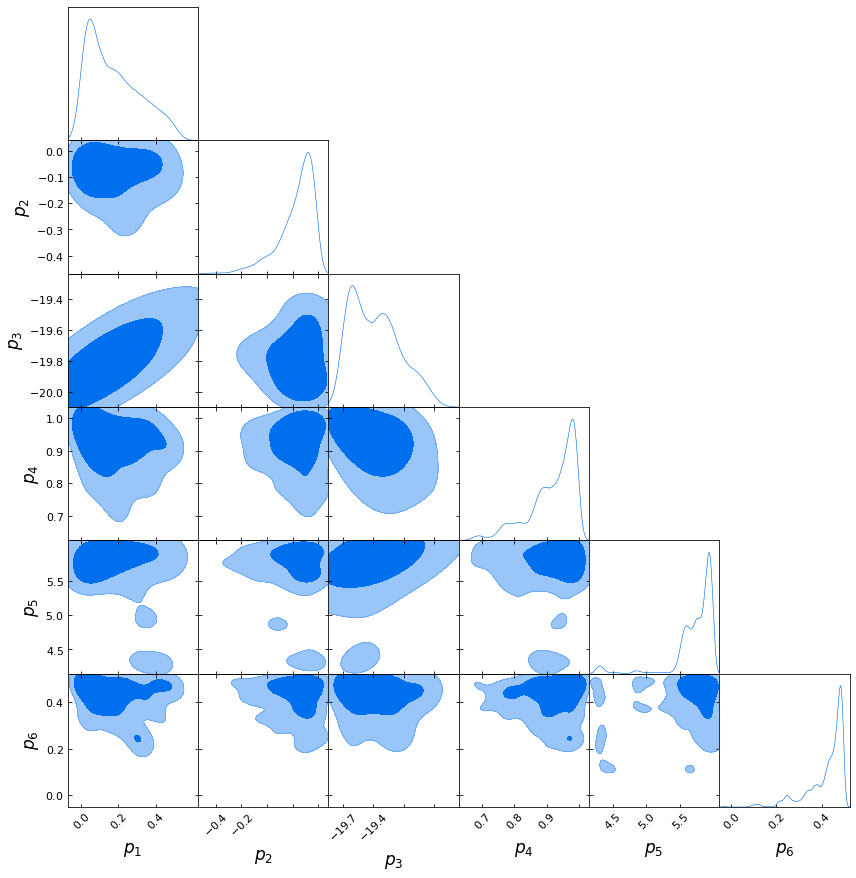

In [15]:
from getdist import plots, MCSamples
import matplotlib as mpl

def triangle_plot(samples = None, weights = None, savefig = False, filename = None, names = None, labels = None, ranges = None):

    # Set samples to the posterior samples by default
    mc_samples = [MCSamples(samples=s, weights = None, names = names, labels = labels, ranges = ranges) for s in samples]

    # Triangle plot
    with mpl.rc_context():
        g = plots.getSubplotPlotter(width_inch = 12)
        g.settings.figure_legend_frame = False
        g.settings.alpha_filled_add=0.6
        g.settings.axes_fontsize=14
        g.settings.legend_fontsize=16
        g.settings.lab_fontsize=20
        g.triangle_plot(mc_samples, filled_compare=True, normalized=True)
        for i in range(0, len(samples[0][0,:])):
            for j in range(0, i+1):
                ax = g.subplots[i,j]
                xtl = ax.get_xticklabels()
                ax.set_xticklabels(xtl, rotation=45)
        plt.tight_layout()
        plt.subplots_adjust(hspace=0, wspace=0)

        if savefig:
            plt.savefig(filename)
        else:
            plt.show()
            
triangle_plot([chain[0].numpy()])

In [26]:
NDEs3[0].log_prob(np.atleast_2d(compressed_data).astype(np.float32), np.atleast_2d(theta_fiducial))

TypeError: in converted code:

    /Users/justinalsing/Dropbox/science/pydelfi-tf2/pydelfi/pydelfi/ndes.py:339 log_prob  *
        _, logp = self.mades[i](u[-1], parameters)
    /usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/engine/base_layer.py:778 __call__
        outputs = call_fn(cast_inputs, *args, **kwargs)
    /Users/justinalsing/Dropbox/science/pydelfi-tf2/pydelfi/pydelfi/ndes.py:159 call  *
        h = self.activations[0](tf.matmul(parameters, self.Wx) + tf.matmul(data, self.Ms[0] * self.Ws[0]) + self.bs[0])
    /usr/local/lib/python3.7/site-packages/tensorflow_core/python/util/dispatch.py:180 wrapper
        return target(*args, **kwargs)
    /usr/local/lib/python3.7/site-packages/tensorflow_core/python/ops/math_ops.py:2798 matmul
        a, b, transpose_a=transpose_a, transpose_b=transpose_b, name=name)
    /usr/local/lib/python3.7/site-packages/tensorflow_core/python/ops/gen_math_ops.py:5626 mat_mul
        name=name)
    /usr/local/lib/python3.7/site-packages/tensorflow_core/python/framework/op_def_library.py:504 _apply_op_helper
        inferred_from[input_arg.type_attr]))

    TypeError: Input 'b' of 'MatMul' Op has type float32 that does not match type float64 of argument 'a'.


In [9]:
prior.log_prob(theta_fiducial.astype(np.float32))

<tf.Tensor: shape=(), dtype=float64, numpy=-2.379546134130174>